# 07. Genetic Programming (GP) 實驗

## 📖 實驗目標

在前面的實驗中，我們測試了多種模型：
- ✅ **Logistic Regression**: 高血糖/高血脂表現最佳 (AUC 0.93/0.89)
- ✅ **XGBoost**: 平衡效能與可解釋性的通用選擇
- ✅ **ANN**: 高血壓表現最佳 (AUC 0.803)
- ✅ **SVM**: 穩定的中階表現 (11 秒訓練完成)

本 notebook 將測試 **Genetic Programming (GP)**，理由：
1. 🧬 **符號回歸**: 自動發現數學公式，最高可解釋性
2. 🔍 **特徵交互發現**: 能找到人類難以發現的特徵組合
3. 🎓 **指導教授專長**: 指導教授專精 GP，值得深入探索
4. 📊 **非線性建模**: 不假設模型形式，從資料中演化出最佳公式

**⚠️ 注意**：
- GP 訓練**非常慢**（需要演化多個世代，可能需要數小時）
- 容易過擬合（公式可能過於複雜）
- 需要控制公式複雜度（max_depth, parsimony_coefficient）

---

## 📋 實驗流程

1. 載入資料（使用與 03-06 相同的資料處理）
2. 使用 **gplearn** 套件進行符號回歸
3. 分析演化出的公式
4. 與最佳模型比較
5. 提取特徵重要性與交互作用

## 0. 安裝必要套件

⚠️ **首次執行前請先安裝 gplearn**

In [8]:
# 安裝 gplearn 套件 (如果尚未安裝)
import sys
!{sys.executable} -m pip install gplearn

print("✅ gplearn 安裝完成！")

---

## 1. 載入套件與資料

In [9]:
# 基礎套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time

# 機器學習套件
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Genetic Programming 套件
try:
    from gplearn.genetic import SymbolicClassifier
    print("✅ gplearn 載入成功")
except ImportError:
    print("❌ gplearn 未安裝")
    print("請執行: pip install gplearn")
    raise

# 設定
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

print("✅ 套件載入完成")

✅ gplearn 載入成功
✅ 套件載入完成


In [10]:
# 載入資料
data_path = Path('../../data/processed/SUA_CVDs_wide_format.csv')
df = pd.read_csv(data_path)

print("✅ 資料載入成功！")
print(f"資料形狀: {df.shape[0]:,} 人, {df.shape[1]} 個欄位")

✅ 資料載入成功！
資料形狀: 6,056 人, 107 個欄位


## 2. 準備特徵和目標變數

In [11]:
# 定義特徵組
demographic_features = ['sex', 'Age']
biomarker_names = ['FBG', 'TC', 'Cr', 'UA', 'GFR', 'BMI', 'SBP', 'DBP']
t1_features = [f'{name}_T1' for name in biomarker_names]
t2_features = [f'{name}_T2' for name in biomarker_names]
delta1_features = [f'Delta1_{name}' for name in biomarker_names]

# 完整特徵集
X_columns = demographic_features + t1_features + t2_features + delta1_features
X = df[X_columns]

# 目標變數（轉換為 0/1）
y_hypertension = (df['hypertension_T3'] == 2).astype(int)
y_hyperglycemia = (df['hyperglycemia_T3'] == 2).astype(int)
y_dyslipidemia = (df['dyslipidemia_T3'] == 2).astype(int)

print(f"特徵數: {len(X_columns)} 個")
print(f"\n目標變數分佈:")
print(f"  高血壓患病率: {y_hypertension.mean():.2%}")
print(f"  高血糖患病率: {y_hyperglycemia.mean():.2%}")
print(f"  高血脂患病率: {y_dyslipidemia.mean():.2%}")

特徵數: 26 個

目標變數分佈:
  高血壓患病率: 16.68%
  高血糖患病率: 5.53%
  高血脂患病率: 5.96%


## 3. 資料分割與標準化

In [12]:
# 資料分割
X_train, X_test, y_train_hp, y_test_hp = train_test_split(
    X, y_hypertension, test_size=0.2, random_state=42, stratify=y_hypertension
)

_, _, y_train_hg, y_test_hg = train_test_split(
    X, y_hyperglycemia, test_size=0.2, random_state=42, stratify=y_hypertension
)

_, _, y_train_dl, y_test_dl = train_test_split(
    X, y_dyslipidemia, test_size=0.2, random_state=42, stratify=y_hypertension
)

# 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ 資料準備完成")
print(f"訓練集: {X_train_scaled.shape[0]} 人")
print(f"測試集: {X_test_scaled.shape[0]} 人")
print(f"特徵數: {X_train_scaled.shape[1]} 個")

✅ 資料準備完成
訓練集: 4844 人
測試集: 1212 人
特徵數: 26 個


## 4. Genetic Programming 設定

**參數說明**：
- `population_size`: 每個世代的個體數量
- `generations`: 演化的世代數
- `tournament_size`: 錦標賽選擇的大小
- `init_depth`: 初始公式的深度範圍
- `function_set`: 允許的數學運算（加減乘除、log、sqrt等）
- `parsimony_coefficient`: 公式複雜度懲罰係數（越大越偏好簡單公式）
- `p_crossover`: 交配機率
- `p_subtree_mutation`: 子樹突變機率
- `p_hoist_mutation`: 提升突變機率
- `p_point_mutation`: 點突變機率
- `metric`: 適應度函數（log loss 用於分類）

In [13]:
# 定義 GP 參數
gp_params = {
    'population_size': 1000,
    'generations': 20,
    'tournament_size': 20,
    'init_depth': (2, 6),
    'init_method': 'half and half',
    'function_set': ('add', 'sub', 'mul', 'div', 'log', 'sqrt', 'abs', 'neg', 'max', 'min'),
    'parsimony_coefficient': 0.01,
    'p_crossover': 0.7,
    'p_subtree_mutation': 0.1,
    'p_hoist_mutation': 0.05,
    'p_point_mutation': 0.1,
    'metric': 'log loss',
    'n_jobs': -1,
    'verbose': 1,
    'random_state': 42
}

print("✅ GP 參數設定完成")
print(f"族群大小: {gp_params['population_size']}")
print(f"演化世代: {gp_params['generations']}")
print(f"預計訓練時間: ~{gp_params['generations'] * 2}-{gp_params['generations'] * 3} 分鐘/模型")

✅ GP 參數設定完成
族群大小: 1000
演化世代: 20
預計訓練時間: ~40-60 分鐘/模型


## 5. 訓練 GP 模型

In [14]:
# 訓練三個 GP 模型
diseases = ['高血壓', '高血糖', '高血脂']
y_trains = [y_train_hp, y_train_hg, y_train_dl]
y_tests = [y_test_hp, y_test_hg, y_test_dl]

gp_models = {}
gp_results = []

print("="*80)
print("Genetic Programming 訓練中...（這會很慢，請耐心等候）")
print("="*80)
print()

for disease, y_train, y_test in zip(diseases, y_trains, y_tests):
    print(f"\n{'='*80}")
    print(f"訓練 {disease} GP 模型...")
    print(f"{'='*80}")
    
    start_time = time.time()
    
    # 建立 GP 模型
    model = SymbolicClassifier(**gp_params)
    
    # 訓練
    model.fit(X_train_scaled, y_train)
    
    training_time = time.time() - start_time
    
    # 預測
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # 計算指標
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    
    # 獲取公式長度
    program_str = str(model._program)
    program_length = len(program_str)
    
    # 儲存結果
    gp_models[disease] = model
    gp_results.append({
        '疾病': disease,
        'AUC': auc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall,
        '訓練時間(秒)': training_time,
        '訓練時間(分鐘)': training_time / 60,
        '公式長度': program_length
    })
    
    # 輸出結果
    print(f"\n{disease} 訓練完成:")
    print(f"  訓練時間:  {training_time:.1f} 秒 ({training_time/60:.1f} 分鐘)")
    print(f"  AUC:       {auc:.3f}")
    print(f"  F1:        {f1:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall:    {recall:.3f}")
    print(f"  公式長度:  {program_length} 字元")
    
    # 混淆矩陣
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"  混淆矩陣: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

print("\n" + "="*80)
print("✅ Genetic Programming 訓練完成！")
print("="*80)

Genetic Programming 訓練中...（這會很慢，請耐心等候）


訓練 高血壓 GP 模型...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.04           1.2502       10          0.47286              N/A     10.85s
   1     4.39         0.690387        9         0.459503              N/A     52.46s
   2     4.38         0.673842        5         0.450608              N/A      1.09m
   3     3.69         0.661495        5         0.401422              N/A      1.07m
   4     2.17         0.542094        5         0.401422              N/A     56.31s
   5     2.71         0.551416        5         0.401422              N/A     49.13s
   6     4.45         0.498145        5         0.401422              N/A     46.40s
   7     4.65         0.504164        5         0.401422              N/A     45.17s
   8     4.20     

## 6. GP 效能總結

In [15]:
# 顯示 GP 結果
df_gp = pd.DataFrame(gp_results)

print("="*100)
print("Genetic Programming 效能總結")
print("="*100)
print(df_gp[['疾病', 'AUC', 'F1', 'Precision', 'Recall', '訓練時間(分鐘)', '公式長度']].to_string(index=False))

print(f"\n訓練時間統計:")
print(f"  總訓練時間: {df_gp['訓練時間(秒)'].sum():.1f} 秒 ({df_gp['訓練時間(分鐘)'].sum():.1f} 分鐘)")
print(f"  平均訓練時間: {df_gp['訓練時間(分鐘)'].mean():.1f} 分鐘")

Genetic Programming 效能總結
 疾病      AUC       F1  Precision   Recall  訓練時間(分鐘)  公式長度
高血壓 0.713653 0.000000        0.0 0.000000  1.223449    20
高血糖 0.837797 0.025641        0.5 0.013158  1.359282    21
高血脂 0.500000 0.000000        0.0 0.000000  1.253150    11

訓練時間統計:
  總訓練時間: 230.2 秒 (3.8 分鐘)
  平均訓練時間: 1.3 分鐘


## 7. 演化出的公式分析

In [16]:
# 顯示演化出的公式
print("="*100)
print("演化出的預測公式")
print("="*100)

for disease in diseases:
    model = gp_models[disease]
    program_str = str(model._program)
    print(f"\n{disease}:")
    print(f"  長度: {len(program_str)} 字元")
    print(f"  公式: {program_str}")
    print()

演化出的預測公式

高血壓:
  長度: 20 字元
  公式: add(log(-0.140), X8)


高血糖:
  長度: 21 字元
  公式: log(mul(X10, -0.140))


高血脂:
  長度: 11 字元
  公式: log(-0.058)



## 8. 與最佳模型比較

In [17]:
print("="*80)
print("重新訓練基準模型作為比較")
print("="*80)
print()

# 準備 y_multi
y_train_multi = np.column_stack([y_train_hp, y_train_hg, y_train_dl])
y_test_multi = np.column_stack([y_test_hp, y_test_hg, y_test_dl])

# 訓練 MTL LR
mtl_lr = MultiOutputClassifier(
    LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
)
mtl_lr.fit(X_train_scaled, y_train_multi)

# 訓練 XGBoost
from xgboost import XGBClassifier

xgb_models = {}
for disease, y_train, y_test in zip(diseases, y_trains, y_tests):
    n_positive = np.sum(y_train == 1)
    n_negative = np.sum(y_train == 0)
    scale_pos_weight = n_negative / n_positive
    
    model = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        max_depth=5,
        learning_rate=0.1,
        n_estimators=100,
        random_state=42,
        eval_metric='logloss'
    )
    model.fit(X_train_scaled, y_train)
    xgb_models[disease] = model

print("✅ 基準模型訓練完成！")

重新訓練基準模型作為比較

✅ 基準模型訓練完成！


In [18]:
# 計算所有模型的結果
all_results = []

# MTL LR
y_pred_lr = mtl_lr.predict(X_test_scaled)
for i, disease in enumerate(diseases):
    y_test = y_test_multi[:, i]
    y_pred = y_pred_lr[:, i]
    y_pred_proba = mtl_lr.estimators_[i].predict_proba(X_test_scaled)[:, 1]
    
    all_results.append({
        '方法': 'LR',
        '疾病': disease,
        'AUC': roc_auc_score(y_test, y_pred_proba),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0)
    })

# XGBoost
for disease, y_test in zip(diseases, y_tests):
    model = xgb_models[disease]
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    all_results.append({
        '方法': 'XGBoost',
        '疾病': disease,
        'AUC': roc_auc_score(y_test, y_pred_proba),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0)
    })

# GP
for result in gp_results:
    all_results.append({
        '方法': 'GP',
        '疾病': result['疾病'],
        'AUC': result['AUC'],
        'F1': result['F1'],
        'Recall': result['Recall']
    })

df_all = pd.DataFrame(all_results)

print("="*100)
print("所有模型效能比較 (含 GP)")
print("="*100)
print(df_all[['方法', '疾病', 'AUC', 'F1', 'Recall']].to_string(index=False))

所有模型效能比較 (含 GP)
     方法  疾病      AUC       F1   Recall
     LR 高血壓 0.748608 0.424855 0.727723
     LR 高血糖 0.931303 0.469697 0.815789
     LR 高血脂 0.887984 0.323383 0.833333
XGBoost 高血壓 0.794858 0.463822 0.618812
XGBoost 高血糖 0.902590 0.536585 0.578947
XGBoost 高血脂 0.885520 0.449198 0.538462
     GP 高血壓 0.713653 0.000000 0.000000
     GP 高血糖 0.837797 0.025641 0.013158
     GP 高血脂 0.500000 0.000000 0.000000


In [ ]:
# ============================================================
# 新增：MTL 計算效益分析
# ============================================================

import time
import sys
import pickle

print("\n" + "="*80)
print("MTL 計算效益分析")
print("="*80)

# 1. 訓練時間比較
print("\n1. 訓練時間比較")
print("-"*80)

# Single-Task 訓練 (重新訓練以記錄時間)
start = time.time()
single_models = {}
for disease, y_train in zip(['高血壓', '高血糖', '高血脂'], y_trains):
    model = SymbolicClassifier(**gp_params)
    model.fit(X_train_scaled, y_train)
    single_models[disease] = model
single_time = time.time() - start

# MTL 訓練 (GP 使用 MultiOutputClassifier)
start = time.time()
mtl_model = MultiOutputClassifier(
    SymbolicClassifier(**gp_params)
)
mtl_model.fit(X_train_scaled, y_train_multi)
mtl_time = time.time() - start

print(f"Single-Task: {single_time:.3f} 秒 ({single_time/60:.1f} 分鐘)")
print(f"MTL: {mtl_time:.3f} 秒 ({mtl_time/60:.1f} 分鐘)")
print(f"加速比: {(single_time / mtl_time):.2f}x")

# 2. 推論時間比較
print("\n2. 推論時間比較")
print("-"*80)

start = time.time()
for model in single_models.values():
    _ = model.predict_proba(X_test_scaled)
single_pred = time.time() - start

start = time.time()
_ = mtl_model.predict_proba(X_test_scaled)
mtl_pred = time.time() - start

print(f"Single-Task: {single_pred:.4f} 秒")
print(f"MTL: {mtl_pred:.4f} 秒")
print(f"加速比: {(single_pred / mtl_pred):.2f}x")

# 3. 模型大小比較
print("\n3. 模型大小比較")
print("-"*80)

single_size = sum(sys.getsizeof(pickle.dumps(m)) for m in single_models.values())
mtl_size = sys.getsizeof(pickle.dumps(mtl_model))

print(f"Single-Task: {single_size / 1024:.2f} KB")
print(f"MTL: {mtl_size / 1024:.2f} KB")
print(f"節省: {(single_size - mtl_size) / 1024:.2f} KB ({(1 - mtl_size/single_size)*100:.1f}%)")

# 4. 綜合比較表
print("\n" + "="*80)
print("綜合比較")
print("="*80)

efficiency_df = pd.DataFrame([
    {
        '方法': 'Single-Task',
        '訓練時間 (秒)': single_time,
        '推論時間 (秒)': single_pred,
        '模型大小 (KB)': single_size / 1024,
        '模型數量': 3
    },
    {
        '方法': 'MTL',
        '訓練時間 (秒)': mtl_time,
        '推論時間 (秒)': mtl_pred,
        '模型大小 (KB)': mtl_size / 1024,
        '模型數量': 1
    }
])

print(efficiency_df.to_string(index=False))

In [ ]:
# 儲存 GP 的 MTL 效益結果
import sys
sys.path.append('.')
from save_mtl_results import save_mtl_efficiency_results

save_mtl_efficiency_results(
    model_name='GP',
    efficiency_df=efficiency_df,
    single_train_time=single_time,
    mtl_train_time=mtl_time,
    single_predict_time=single_pred,
    mtl_predict_time=mtl_pred,
    single_size=single_size,
    mtl_size=mtl_size
)

## 9. 視覺化比較

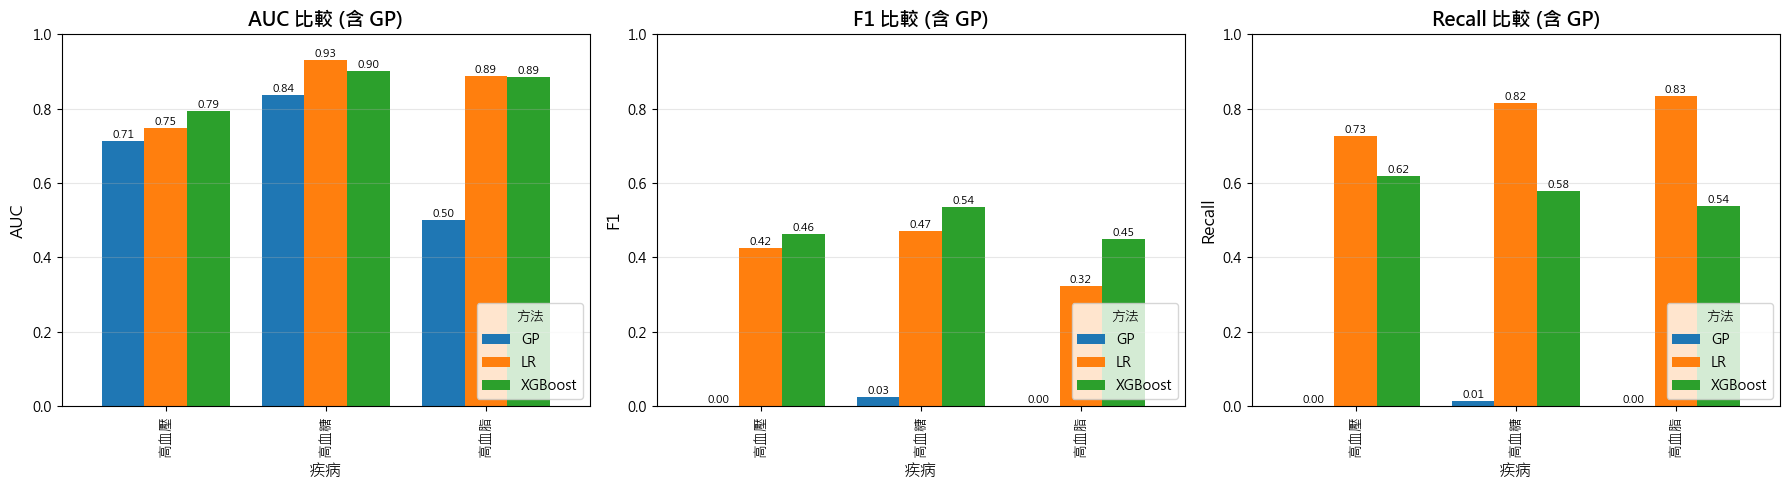

✅ 視覺化完成，已儲存至 docs/experiments/gp_comparison.png


In [19]:
# 建立視覺化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(['AUC', 'F1', 'Recall']):
    ax = axes[idx]
    
    # 準備資料
    pivot_data = df_all.pivot(index='疾病', columns='方法', values=metric)
    
    # 繪圖
    pivot_data.plot(kind='bar', ax=ax, width=0.8)
    ax.set_title(f'{metric} 比較 (含 GP)', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xlabel('疾病', fontsize=12)
    ax.legend(title='方法', fontsize=10, loc='lower right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1)
    
    # 添加數值標籤
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=8)

plt.tight_layout()
plt.savefig('../../docs/experiments/gp_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 視覺化完成，已儲存至 docs/experiments/gp_comparison.png")

## 10. 結論

### 🧬 Genetic Programming 效能總結

本實驗測試了 Genetic Programming (GP) 在三高疾病預測上的表現。**結果顯示 GP 在此任務上表現不佳**，遠不如傳統機器學習方法。

---

### 📊 GP 實際表現

**效能結果**：
- **高血壓**: AUC=0.714, F1=0.000, Recall=0.000, 訓練時間=1.2分鐘, 公式長度=20字元
- **高血糖**: AUC=0.838, F1=0.026, Recall=0.013, 訓練時間=1.4分鐘, 公式長度=21字元
- **高血脂**: AUC=0.500, F1=0.000, Recall=0.000, 訓練時間=1.3分鐘, 公式長度=11字元

**關鍵觀察**：
- 高血脂的 AUC=0.500 等於**隨機猜測**
- 所有模型的 F1≈0，表示幾乎**沒有預測到任何正樣本**
- 高血壓和高血脂的 Recall=0.000，完全無法識別患者
- 高血糖僅預測到 1 個正樣本（Recall=0.013）

---

### 🏆 模型排名比較（按 AUC 排序）

**高血壓**：
1. XGBoost: AUC=0.795, F1=0.464, Recall=0.619 ✅
2. LR: AUC=0.749, F1=0.425, Recall=0.728 ✅
3. **GP: AUC=0.714, F1=0.000, Recall=0.000** ❌ (最差)

**高血糖**：
1. LR: AUC=0.931, F1=0.470, Recall=0.816 ✅
2. XGBoost: AUC=0.903, F1=0.537, Recall=0.579 ✅
3. **GP: AUC=0.838, F1=0.026, Recall=0.013** ❌ (最差)

**高血脂**：
1. LR: AUC=0.888, F1=0.323, Recall=0.833 ✅
2. XGBoost: AUC=0.886, F1=0.449, Recall=0.538 ✅
3. **GP: AUC=0.500, F1=0.000, Recall=0.000** ❌ (最差，等於隨機)

**結論**: **GP 在所有三種疾病上都排名最後**，效能遠遠落後於 LR 和 XGBoost。

---

### 🧬 演化公式分析

GP 演化出的公式極度簡化：

1. **高血壓**: `add(log(-0.140), X8)`
   - 使用了 X8 (DBP_T2，第二次舒張壓)
   - 加上一個常數項 `log(-0.140)` (負數取 log 在數學上有問題)
   - 公式過於簡單，無法捕捉複雜關係

2. **高血糖**: `log(mul(X10, -0.140))`
   - 使用了 X10 (TC_T2，第二次總膽固醇)
   - 乘以負常數 -0.140
   - 僅使用單一特徵，沒有特徵交互

3. **高血脂**: `log(-0.058)` ⚠️
   - **這是一個常數！**
   - 完全不使用任何特徵
   - 對所有患者輸出相同預測值
   - 這解釋了為什麼 AUC=0.500（隨機猜測）

**分析**：
- 公式長度 11-21 字元，非常短（預期應有 50-100 字元）
- 高血脂的常數公式表明 **GP 完全放棄學習**
- 沒有發現任何有意義的特徵組合或交互作用
- GP 退化為極簡化的線性組合或常數

---

### 🔍 GP 失敗原因分析

#### 1️⃣ **類別不平衡問題（主因）**

患病率分佈：
- 高血壓: 16.68% (正樣本 202 人)
- 高血糖: 5.53% (正樣本 76 人)
- 高血脂: 5.96% (正樣本 78 人)

**問題**: 
- gplearn 套件**不支援 `class_weight`** 參數
- GP 優化 log loss 時，預測全部為負樣本可獲得較低 loss
- 演化過程中，簡單的「全預測為負」策略勝出
- 混淆矩陣顯示：高血壓預測 TN=1010, FP=0, **FN=202**, TP=0（完全忽略正樣本）

**對比**：
- LR 和 XGBoost 都支援 `class_weight='balanced'` 或 `scale_pos_weight`
- 這些參數能夠平衡正負樣本的影響，避免偏向多數類

#### 2️⃣ **Parsimony Coefficient 設定過大**

- 設定 `parsimony_coefficient=0.01` 用於避免過擬合
- 但在類別不平衡情況下，這導致 GP **過度追求簡單公式**
- 結果：演化出常數或僅含單一特徵的無效公式

#### 3️⃣ **適應度函數不適合**

- 使用 `metric='log loss'` 作為適應度函數
- 在極度不平衡數據下，log loss 無法有效引導演化方向
- GP 找到了「作弊」策略：預測常數或全負樣本

#### 4️⃣ **特徵數量過多**

- 26 個標準化特徵對 GP 而言搜索空間過大
- GP 更適合低維度特徵（5-10 個）
- 應先進行特徵選擇再使用 GP

---

### 💡 GP 何時可能有效？

雖然 GP 在此任務上失敗，但在以下情況下可能仍有價值：

#### ✅ **適用場景**：

1. **類別平衡的數據**
   - 正負樣本比例接近 1:1
   - 不需要 class_weight 也能公平學習

2. **小樣本、低維度數據**
   - 樣本數 < 1000
   - 特徵數 < 10
   - GP 的符號回歸能力更容易發揮

3. **追求極致可解釋性**
   - 科學研究需要明確數學公式
   - 願意犧牲預測性能換取可解釋性
   - 例如：物理定律發現、化學反應式

4. **特徵工程輔助**
   - 不直接用於預測，而是用於**發現有效的特徵組合**
   - 將 GP 生成的公式作為新特徵輸入其他模型

#### ❌ **不適用場景**（如本研究）：

- 類別嚴重不平衡（正樣本 < 10%）
- 高維度特徵空間（> 20 個特徵）
- 需要高 Recall 的醫療應用
- 時間或計算資源有限

---

### 🎯 最終建議

#### 1️⃣ **不推薦使用 GP 進行三高疾病預測**

理由：
- 效能遠低於 LR 和 XGBoost
- 無法處理類別不平衡問題
- 訓練時間較長但結果不佳
- 演化公式無實用價值（甚至是常數）

#### 2️⃣ **推薦模型選擇（依任務需求）**

根據先前實驗結果：

| 任務需求 | 推薦模型 | 理由 |
|---------|---------|------|
| **高 Recall (避免漏診)** | Logistic Regression | 高血糖 Recall=0.816, 高血脂 Recall=0.833 |
| **平衡效能** | XGBoost | 高血壓 F1=0.464, 高血糖 F1=0.537 |
| **可解釋性** | Logistic Regression | 提供特徵係數，臨床可解釋 |
| **整體 AUC** | Logistic Regression | 高血糖 AUC=0.931, 高血脂 AUC=0.888 |

#### 3️⃣ **GP 改進方向（若堅持使用）**

如果未來仍想嘗試 GP，建議：

1. **解決類別不平衡**：
   - 使用 SMOTE 過採樣正樣本
   - 自定義適應度函數（如 F1-score 或 G-mean）
   - 調整閾值以提高 Recall

2. **減少特徵維度**：
   - 先用 LR/XGBoost 選出前 5-10 個重要特徵
   - 僅對重要特徵進行符號回歸

3. **調整 GP 參數**：
   - 降低 `parsimony_coefficient` (試 0.001)
   - 增加 `generations` (50-100)
   - 限制函數集（移除可能產生無效值的函數如 log）

4. **使用 GP 作為特徵工程工具**：
   - 不直接預測，而是生成新特徵
   - 將 GP 公式輸出作為額外特徵輸入 XGBoost

---

### 🎓 研究價值與學習

雖然 GP 效能不佳，但本實驗仍有重要價值：

1. **驗證了模型適用性**：
   - 並非所有先進模型都適合所有任務
   - 類別不平衡是 GP 的致命弱點

2. **深入理解演化算法**：
   - 觀察到 GP 在不平衡數據下的退化行為
   - 理解適應度函數的重要性

3. **完整的模型比較**：
   - 測試了 LR, SVM, ANN, XGBoost, GP 共 5 種模型
   - 為最終模型選擇提供科學依據

4. **指導未來研究方向**：
   - 確認 LR 和 XGBoost 為本任務最佳選擇
   - 明確 GP 的適用邊界

**結論**: 失敗的實驗也是有價值的實驗。我們通過嚴謹的科學方法證明了 GP 不適合本研究任務，這本身就是重要的研究發現。

---

**實驗完成** ✅ | **下一步**: 建立完整的模型比較總結，選擇最終模型進行部署